#**3D Multi-Particles LJ Potential MC Sampling and Replica Exchange Moleuclar Dynamics**
**Yinuo Yang**

This report is consisted of four parts:<br>
**I. Set up Monte Carlo Simulation**<br>
**II. Test the MC Simulation**<br>
**III. Set up Replica Exchange MD simulation**<br>
**IV. Test the REMD**<br>

##**I. Set up Monte Carlo Simulation**
Herein, several useful functions are defined:<br>
(a) Periodic distance function **dis_1()** and **distance()**<br>
(b) Total LJ potential for a periodic box **V_LJ()**<br>
(c) Random number generation function**get_rand()**<br>
(d) Boltzmann distribution function **get_boltz()**<br>
(e) Fix the range of three dimensions **fix_range1()** and **fix_range()**<br>
(f) Move acception/rejection function **decide_LJ()**<br>
(e) Function to initiate the N points coordinates **init_coor()**<br>
(f) Monte Carlo Simulation function **MC_coor()**<br>


In [0]:
import random
from random import randrange
import numpy as np
import time
import sympy as sym
import math
import scipy as sci
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as mplpyl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline 


### Default values ###
kb = 1.98*(10**(-3))          # Boltzmann constant in kcal/mol.K
eps = 3                       # units in kcal/mol
sigma = 2                     # units in angstrom (for LJ potential)
T = 300                       # units in kelvin
N = 50                        # number of points within the box
Nstep = 100                   # number of steps
minx   =  -10                 # Minimum of x
maxx   =  10                  # Maximum of x
rangex = maxx - minx          # Boxsize on x dimension
miny = -10
maxy = 10
rangey = maxy - miny
minz = 0
maxz = 0
rangez = maxz - minz         # z-dimension is listed here, but I make the range of z as 0, so that it is still a two-dimention system
dx = 2
dy = 2
dz = 0 

cutoff = 9                   # cutoff < boxsize/2

In [0]:
def dis_1(x_t, x, rangex): 
  '''
  This function is used to get the periodic distance on one dimension
  x, x_t: the one dimension coordinate of two points x & x_t
  rangex: the boxsize on this dimension
  This function works by returning the minimum of one dimension two point distances (both in-box distance & cross-box distance)
  '''
  xa = np.abs(x_t - x)
  xb = rangex - xa
  return min(xa, xb)


def distance(x_t, y_t, z_t, x, y, z): 
  '''
  This function is used to get the periodic distance between two points on three dimensions
  '''
  xd = dis_1(x_t, x, rangex)
  yd = dis_1(y_t, y, rangey)
  zd = dis_1(z_t, z, rangez)
  r = np.sqrt(xd**2 + yd**2 + zd**2)
  return r


def V_LJ(xlist, ylist, zlist): 
  '''
  This function is used to calculate the total LJ potential of N pts in a periodical box
  The LJ potential is applied within a cutoff
  '''  
  V = 0                                
  for i in range(N):        # N points, N=50
    for j in range(i):
      r = distance(xlist[i], ylist[i], zlist[i], xlist[j], ylist[j], zlist[j])    # calculate distance between ith point & jth point
      if r < cutoff:        # Only consider distance smaller than cutoff
        v = 4*eps*((sigma/r)**12 - (sigma/r)**6)
        V += v              # Cumulate all the inter-points potentials within cutoff
  return V


def get_rand(min, max, sd=time.time()):  # generate a random float value between min and max
  random.seed(sd)
  randnum = random.uniform(min, max)
  return randnum



def get_boltz(dV, T):         
  '''
  This function determines the probability of accepting or rejecting a move according to a Boltzmann distribution
  dV = Difference in potential between the previous and trial state
  '''
  beta = 1/(kb*T)            
  boltz = np.exp(-beta*dV)
  return boltz


def fix_range1(x, maxx, minx):     
  '''
  This function is used to check if a move is cross a box on x dimension.
  If true, send this point back within the x range
  '''
  if x > maxx:
    x -= (maxx - minx)
  elif x <= minx:
    x += (maxx - minx)
  return x

def fix_range(x, y, z):
  '''
  This function is used to check if a move is cross a box on three dimensions.
  If true, send this point back to the inside of the box
  '''
  x = fix_range1(x, maxx, minx)
  y = fix_range1(y, maxy, miny)
  z = fix_range1(z, maxz, minz)
  return x, y, z


def decide_LJ(V_t, V, x_t, y_t, z_t, x, y, z, T, counter):
  '''
  This is the decide function for LJ potential, it is used to accept/reject a move
  x_t,y_t,z_t,x,y,z are all lists of all N points inside the box
  '''
  prob = get_rand(0,1,time.time())
  dV = (V_t - V) 
  boltz = get_boltz(dV,T)     # calculate boltzmann distribution probability
  if prob < boltz:            # accept a move   
    x = x_t
    y = y_t
    z = z_t
    V = V_t
    counter += 1              # 'counter' is used for calcuating acceptance rate
  else:                       # reject a move
    x = x
    y = y
    z = z
    V = V
  return V, x, y, z, counter # return decided potential/coordinates and number of accepted moves


def init_coor(N): 
  '''
  This function is used to initiate the coordinates of N data points
  All the coordinates are randomly picked within the boxsize
  It returns all the coordinates and the potential V
  '''
  xlist = []                       # create empty list to save x coordinates
  ylist = []
  zlist = []
  for i in range(N):
    x = random.uniform(minx, maxx)
    y = random.uniform(miny, maxy)
    z = random.uniform(minz, maxz)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)
  V = V_LJ(xlist, ylist, zlist)    # call the potential function V_LJ for the total potential within a box
  return xlist,ylist,zlist,V



def MC_coor(N,Nstep,Nmove,T,xlist,ylist,zlist,V):   # N: num of points in box, Nstep: num of MC steps, Nmove: num of points doing MC move in one step
  '''
  This function is used to do Metropolis Monte Carlo to a random subset of N points (Nmove points)
  For each step, the random Nmove points will take a random move on x/y/z dimensions, decide_LJ function will be used here to accept/reject a move
  '''
  counter = 0

  for i in range(Nstep):                   # Do MC for Nstep iterations

    klist = []                             # generate random keys between 0~49, save these keys in klist
    while len(klist) < Nmove:
      k = randrange(N)
      if k not in klist: klist.append(k)

    xlist_t = []                           # create empty trial list to save trial x coordinates for N points
    ylist_t = []
    zlist_t = []
    for j in range(N):                     # for N points, get the trial coordinates for each point
      if j in klist:                       # if j belongs to klist (randomly picked Nmove points), take a MC move for each of them
        deltax = random.uniform(-dx, dx)
        deltay = random.uniform(-dy, dy)
        deltaz = random.uniform(-dz, dz)
        x_t = xlist[j] + deltax            # x_t is the trial x coordinate for jth point 
        y_t = ylist[j] + deltay
        z_t = zlist[j] + deltaz
        x_t,y_t,z_t = fix_range(x_t, y_t, z_t)   # check if the point is outside of box, if yes return it back
      else:
        x_t = xlist[j]                     # if j do not belong to klist, keep their original coordinates
        y_t = ylist[j]
        z_t = zlist[j]
      xlist_t.append(x_t)                  # Put all the trial coordinates into the trial list for N points
      ylist_t.append(y_t)
      zlist_t.append(z_t)

    V_t = V_LJ(xlist_t, ylist_t, zlist_t)  # calculate the trial potential for the trial coordinates
    V, xlist, ylist, zlist, counter = decide_LJ(V_t, V, xlist_t, ylist_t, zlist_t, xlist, ylist, zlist, T, counter)    # decide if accept this MC move
    acc_rate = counter / Nstep * 100       # acceptance rate
  return xlist,ylist,zlist,V,acc_rate

##**II. Test the MC Simulation**<br>
###**(1) Intuitively test the MC simulation** (N=50,Nstep=1000,Nmove=1,T=300K,dx=dy=2)<br>
At the very begining, an intuitive MC test is considered. Fig 0-a shows the coordinates of initial N=50 points. Fig 0-b shows the final coordinates after taking Nstep=1000 MC steps. From Fig 0-a to Fig 0-b, the distribution of N points are more regulated and the total LJ potential is much lowered. In the following parts, tests will be conducted to check if my MC simulation code is correct.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


The initial LJ potential is  3519333082.730265
The final LJ potential is  -163.01105190654553


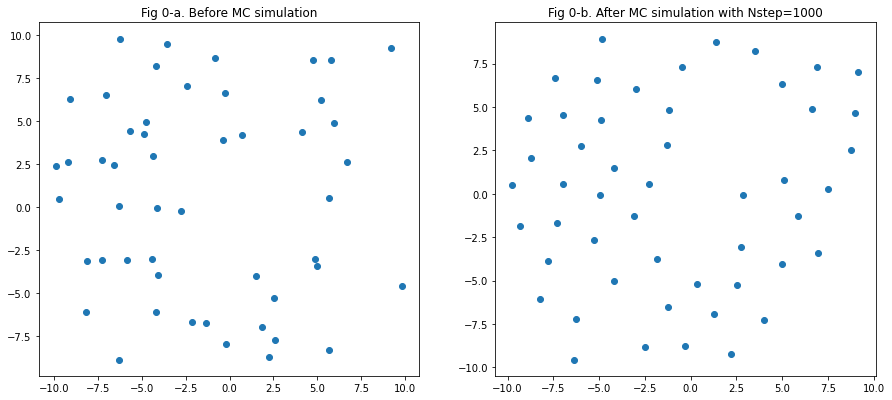

In [0]:
Nstep = 1000
Nmove = 1            # do MC move for only one point in each step
fig, axs = plt.subplots(1, 2, figsize=(15,6.5))
axs = axs.ravel()
x_ini, y_ini, z_ini, V_ini = init_coor(N)         # get the initial coordinates and potential for a box with default size (20*20*0, N=50 points)
axs[0].scatter(x_ini,y_ini)
axs[0].set_title('Fig 0-a. Before MC simulation')
x_MC, y_MC, z_MC, V_MC, acc_rate = MC_coor(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)    # Do Nstep=1000 MC steps, get the final coordiantes/potential/acceptance rate (default stepsize dx=dy=2, T=300K)
axs[1].scatter(x_MC,y_MC)
axs[1].set_title('Fig 0-b. After MC simulation with Nstep=1000')
print('The initial LJ potential is ', V_ini)
print('The final LJ potential is ', V_MC)

###**(2) Test the cutoff distance**<br>
As shown in Fig 1, the cutoff distance is set to 5. The orange pt is the center point while the blue ones are points within the cutoff. Only the blue points are considered in the LJ-potential calculation. According to this figure, the cutoff and periodicity distance work well in the potential function.

coordinates for center point: -2.8525693269855124 9.140600907918142
LJ potential of center point: 84205994.26904643


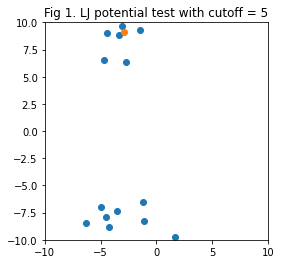

In [0]:
### Test if cutoff works in LJ potential calculation ###

def cutoff_test(xlist, ylist, zlist, cutoff_t):    # cutoff_t is the tested cutoff (avoid confusion with the default constant cutoff=9)
  '''
  This function is used to show all points that are considered in a potential calculation 
  It is used to test if cutoff works in the potential calculation
  '''  
  V = 0 
  k = randrange(N)        # randomly pick a key for one point
  k_x = []                # a list used to save x_coordinate of points that are considered in potential computation for the center point (kth point)
  k_y = []
  for i in range(N):      # a loop for all N=50 points
    if i == k:            # if i is the center point(k), no potential is added
      V += 0
      kx = xlist[i]       # save center point(k) to kx and ky
      ky = ylist[i]
    else:                 # if i not the center point, calculate distance btween i and k, if within cutoff, two-point potential is added
      r = distance(xlist[i], ylist[i], zlist[i], xlist[k], ylist[k], zlist[k])   
      if r < cutoff_t:
        v = 4*eps*((sigma/r)**12 - (sigma/r)**6)
        V += v
        k_x.append(xlist[i])    # add coords of points within cutoff_t to k_x, k_y list
        k_y.append(ylist[i])
  return kx, ky, V, k_x, k_y    # return center point (kx,ky), potential V, and points considered in potential calculation (k_x, k_y lists)

xlist, ylist, zlist, V_tot = init_coor(N)     # get the initial coordinates and potential for a box with default size (20*20*0, N=50 points)
kx, ky, Vk, k_x, k_y = cutoff_test(xlist, ylist, zlist, cutoff_t = 5)  # get center point(kx/ky), ptential Vk, and points considered in potential calculation (k_x, k_y lists)
plt.figure(figsize=[4,4])
plt.scatter(k_x, k_y)           # scatter center point (kx,ky)
plt.scatter(kx,ky)              # scatter points that are considered in potential calculation of center point
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title('Fig 1. LJ potential test with cutoff = 5')
print('coordinates for center point:', kx,ky)
print('LJ potential of center point:', Vk)

###**(3) Test the MC moves** (N=50,Nstep=200,T=300K)<br>
Firstly, I consider move 1 point at one step (Nmove=1). Fig 2 plots the acceptance rate changes with the maximum stepsize for dx and dy (dz=0). The acceptance rate decreases with the increase of stepsize, which is in accordance with the MC simulation. For the following simulation, dx = 2, dy = 2 are chosen to  be the default stepsize.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Fig 2. Acceptance rate vs stepsize (Nmove=1)')

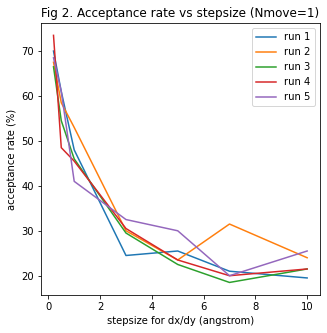

In [0]:
### Test MC moves ###

### (a) move one point at a time ###
Nmove = 1
Nstep = 200
stepsize = [0.2,0.5,1,3,5,7,10]     
x_ini, y_ini, z_ini, V_ini = init_coor(N)   # get initial coordinates/potential for N=50 points (boxsize:20*20*0)

plt.figure(figsize=[5,5])

for i in range(5):    # repeat for 5 runs
  acc_list = []       
  for dx,dy in zip(stepsize,stepsize):    # test for different stepsize(dx/dy), change dx/dy simultaneously
    x_MC,y_MC,z_MC,V_MC,acc_rate = MC_coor(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)    # Do MC for Nstep=200 times with Nmove=1, T=300K
    acc_list.append(acc_rate)        # save acceptance rate changes with stepsize
  plt.plot(stepsize, acc_list, label='run %s'%(i+1))     # plot acceptance rate vs stepsize

plt.legend()
plt.xlabel('stepsize for dx/dy (angstrom)')
plt.ylabel('acceptance rate (%)')
plt.title('Fig 2. Acceptance rate vs stepsize (Nmove=1)')


Secondly, test on moving multiple points at one step is considered (Nmove = 1,5,10,15,20,30,50). Fig 3 plots the acceptance rate changes with the Nmoves. The acceptance rate decreases exponentially with the increase of Nmove. In the following MC simulation, a high acceptance rate and the number of moving points are all important in simulations. To balance these two factors, I pick Nmove = 5 for the following simulations.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Fig 3. Acceptance rate vs Nmoves')

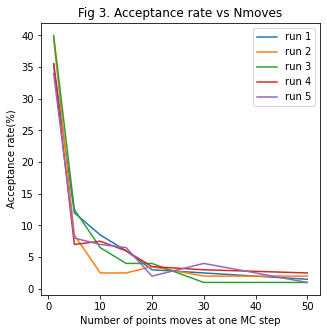

In [0]:
### Test MC moves ###
### (b) move multiple points at a time ###

Nstep = 200
Nmove_list = [1,5,10,15,20,30,50]
x_ini, y_ini, z_ini, V_ini = init_coor(N)       # get initial coordinates/potential for N=50 points (boxsize:20*20*0)

plt.figure(figsize=[5,5])

for i in range(5):     # repeat for 5 runs
  acc_list = []
  for Nmove in Nmove_list:      # test for different Nmove(num of points that moves during one MC step)
    x_MC,y_MC,z_MC,V_MC,acc_rate = MC_coor(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)   # do MC for diff Nmoves (N=50 points, Nstep=200, T=300K)
    acc_list.append(acc_rate)
  plt.plot(Nmove_list, acc_list, label='run %s'%(i+1))

plt.legend()
plt.xlabel('Number of points moves at one MC step')
plt.ylabel('Acceptance rate(%)')
plt.title('Fig 3. Acceptance rate vs Nmoves')


###**(4) Test the effect of temperature/epsilon** (N=50,Nstep=1000,Nmove=5)<br>
In Fig 4, I tried to test the effect how temperature and epsilon affects the LJ-potential. However, the plots does not give me clear trend on these two factors. After double check on the decide function, I found that the total LJ potential for N=50 points is usually a very large number, which means dV(change of potential) is always a very large number (positively or negatively). The temperature factor works when dV can be a small positive number (it accept a move when dV is negative or dV is a very small positive value). However, since the positive dV is always very large, it makes no difference when temperature changes.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Fig 4. Acceptance rate vs Temp with different epsilon')

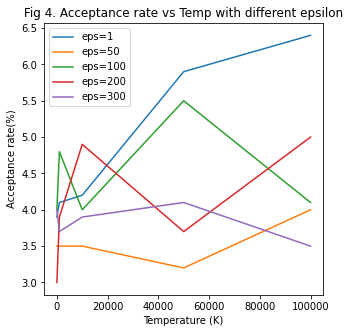

In [0]:
### Test the effect of temperature and epsilon ###

Nstep = 1000
Nmove = 5
T_list = [10,1000,10000,50000,100000]
eps_list = [1,50,100,200,300]
x_ini, y_ini, z_ini, V_ini = init_coor(N)     # get initial coordinates/potential for N=50 points (boxsize:20*20*0)

plt.figure(figsize=[5,5])

for eps in eps_list:         # test for different epsilon
  acc_list = []
  for T in T_list:           # test for different Temp
    x_MC,y_MC,z_MC,V_MC,acc_rate = MC_coor(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)      # do MC (N=50 points, Nmove=5, Nstep=1000)
    acc_list.append(acc_rate)
  plt.plot(T_list, acc_list, label='eps=%s'%(eps))
  
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Acceptance rate(%)')
plt.title('Fig 4. Acceptance rate vs Temp with different epsilon')

###**(5) Create the trajectory of MC simulation**<br>
Herein, a 'MC_simulation_trj.xyz' file was created to track the trajectory of moves. This file can be visualized in Avogadro and is attached in my submission

In [0]:
### create the trajectory of MC simulation ###
from google.colab import files
f = open('MC_simulation_trj.xyz','w')
Nstep = 100
Nmove = 2
xlist, ylist, zlist, V = init_coor(N)
f.write('50\n')
f.write('comment\n')
for i in range(N):
  f.write('H   %s   %d   %f \n'%(xlist[i],ylist[i],zlist[i]))     # print the initial coordinates (imaging all of the points are hydrogen)

counter = 0
for i in range(Nstep):                   # print coordinates for each step
  klist = []
  while len(klist) < Nmove:              # ramdomly pick Nmove=2 keys and save in klist
    k = randrange(N)
    if k not in klist: klist.append(k)
  xlist_t = []                           # create empty trial list to save trial x coordinates for N points
  ylist_t = []
  zlist_t = []
  for j in range(N):                     # for N=50 points
    if j in klist:                       # if j is the picked Nmove points, make a move
      deltax = random.uniform(-dx, dx)
      deltay = random.uniform(-dy, dy)
      deltaz = random.uniform(-dz, dz)
      x_t = xlist[j] + deltax
      y_t = ylist[j] + deltay
      z_t = zlist[j] + deltaz
      x_t,y_t,z_t = fix_range(x_t, y_t, z_t)
    else:                                # if j is not the picked Nmove points, do not change its coordinates
      x_t = xlist[j]
      y_t = ylist[j]
      z_t = zlist[j]
    xlist_t.append(x_t)                  # add the coordinates of jth point to the trial list
    ylist_t.append(y_t)
    zlist_t.append(z_t)
  V_t = V_LJ(xlist_t, ylist_t, zlist_t)  # calculate the trial potential for trial coordinates
  V, xlist, ylist, zlist, counter = decide_LJ(V_t, V, xlist_t, ylist_t, zlist_t, xlist, ylist, zlist, T, counter)  # decide if taking the move (N=50,Nstep=100,Nmove=2,T=300K)
  f.write('50\n')
  f.write('comment\n')
  for i in range(N):
    f.write('H   %s   %d   %f \n'%(xlist[i],ylist[i],zlist[i]))  # write the coordinated for ith MC step.

f.close()
files.download('MC_simulation_trj.xyz')   # download the trajectory file

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


###**(6) Test the convergence of the MC simulation (ergodicity)**<br>
Firstly, an average total potential vs Nstep plot was made in Fig 5. Multiple runs were conducted and shows the same convergence on the average potential. Pay attention that the y-axis has a very large range. (N=50,Nstep=5000,Nmove=5,T=300K,dx=dy=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Fig 5. Average total potential vs Nsteps for multiple runs')

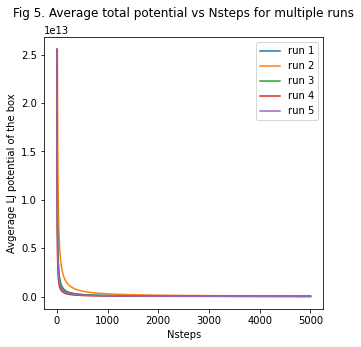

In [0]:
### Convergence of MC simulation (no replica exchange) ###
### (a) average total potential vs Nstep ###

def MC_avg_V(N,Nstep,Nmove,T,xlist,ylist,zlist,V):
  '''
  This fn is used to track the average total potential and plot it vs Nstep
  This fn is almost the same as the MC_coor function defined above. 
  (The only difference is it records the average total potential trajectory)
  '''
  counter = 0                             # used for acceptance rate calculation
  Nc = 1                                  # used for counting the steps
  Vlist = [V]                             # save total potential trajectory
  avg_Vlist = [V]                         # save average total potential with Nstep (ergodicity)
  Nlist = [Nc]                            # save 1,2,3,4,....,Nstep
  for i in range(Nstep):
    klist = []
    while len(klist) < Nmove:             # ramdomly pick Nmove keys and save in klist
      k = randrange(N)
      if k not in klist: klist.append(k)
    xlist_t = []
    ylist_t = []
    zlist_t = []
    for j in range(N):            
      if j in klist:
        deltax = random.uniform(-dx, dx)
        deltay = random.uniform(-dy, dy)
        deltaz = random.uniform(-dz, dz)
        x_t = xlist[j] + deltax
        y_t = ylist[j] + deltay
        z_t = zlist[j] + deltaz
        x_t,y_t,z_t = fix_range(x_t, y_t, z_t)
      else:
        x_t = xlist[j]
        y_t = ylist[j]
        z_t = zlist[j]
      xlist_t.append(x_t)
      ylist_t.append(y_t)
      zlist_t.append(z_t)
    V_t = V_LJ(xlist_t, ylist_t, zlist_t)
    V, xlist, ylist, zlist, counter = decide_LJ(V_t, V, xlist_t, ylist_t, zlist_t, xlist, ylist, zlist, T, counter)
    Nc += 1
    Nlist.append(Nc)
    Vlist.append(V)
    avg_Vlist.append(sum(Vlist)/len(Vlist))
  return avg_Vlist, Nlist

Nstep = 5000
Nmove = 5
x_ini, y_ini, z_ini, V_ini = init_coor(N)
plt.figure(figsize=[5,5])

for i in range(5):
  avg_Vlist, Nlist = MC_avg_V(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)
  plt.plot(Nlist,avg_Vlist,label='run %s'%(i+1))
plt.legend()
plt.xlabel('Nsteps')
plt.ylabel('Avgerage LJ potential of the box')
plt.title('Fig 5. Average total potential vs Nsteps for multiple runs',pad=20)


Secondly, I plot the average potential for each particle vs Nstep in Fig 6 (the following figure). Note that I limit the y-axis to a much smaller range (0-100000) comparing to Fig 5. Since this plot is super time-consuming, I only test for Nstep=10000 MC steps. The average potentials for each point show a clear trend to converge, but not totally converged. (N=50,Nstep=10000,Nmove=5,T=300K,dx=dy=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Average LJ-potential vs Nsteps for each particle (ergodicity)')

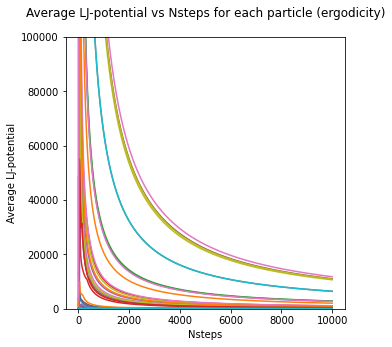

In [0]:
### Convergence of MC simulation (no replica exchange) ###
### (b) average potential for each particle  ###
def V_LJ_one(xlist,ylist,zlist,key):
  '''
  This fn is used to calculate the potential between the keyth point and other points 
  '''
  V_one = 0
  for i in range(N):
    if i == key:
      V_one += 0
    else:
      r = distance(xlist[i], ylist[i], zlist[i], xlist[key], ylist[key], zlist[key])   
      if r < cutoff:
        v = 4*eps*((sigma/r)**12 - (sigma/r)**6)
        V_one += v
  return V_one

def MC_avg_Vone(N,Nstep,Nmove,T,xlist,ylist,zlist,V):
  '''
  This fn is used to track the average potential for each particle
  This fn is almost the same as the MC_coor function defined above. 
  (The only difference is it records the total potential for each point)
  '''
  counter = 0                             # used for acceptance rate calculation
  Nc = 0                                  # used to count the steps
  Nlist = []                              # save 1,2,3,4,....,Nstep
  Vone_traj = [[] for i in range(N)]      # 2d-array, Vone_traj[i][j] is the ith point's potential at jth MC step
  avg_Vone_traj = [[] for i in range(N)]  # 2d-array, avg_Vone_traj[i][j] is the ith point's average potential calculated at jth MC step
  for i in range(Nstep):                  
    klist = []
    while len(klist) < Nmove:             # ramdomly pick Nmove keys and save in klist
      k = randrange(N)
      if k not in klist: klist.append(k)
    xlist_t = []
    ylist_t = []
    zlist_t = []
    for j in range(N):            
      if j in klist:
        deltax = random.uniform(-dx, dx)
        deltay = random.uniform(-dy, dy)
        deltaz = random.uniform(-dz, dz)
        x_t = xlist[j] + deltax
        y_t = ylist[j] + deltay
        z_t = zlist[j] + deltaz
        x_t,y_t,z_t = fix_range(x_t, y_t, z_t)
      else:
        x_t = xlist[j]
        y_t = ylist[j]
        z_t = zlist[j]
      xlist_t.append(x_t)
      ylist_t.append(y_t)
      zlist_t.append(z_t)
    V_t = V_LJ(xlist_t, ylist_t, zlist_t)
    V, xlist, ylist, zlist, counter = decide_LJ(V_t, V, xlist_t, ylist_t, zlist_t, xlist, ylist, zlist, T, counter)
    Nc += 1
    Nlist.append(Nc)
    for key in range(N):                  # record the potential and average potential for each point at each step(Vone_traj & avg_Vone_traj)
      Vone = V_LJ_one(xlist,ylist,zlist,key)
      Vone_traj[key].append(Vone)
      avg_Vone_traj[key].append(sum(Vone_traj[key])/len(Vone_traj[key]))

  return Nlist, avg_Vone_traj             # return Nlist(1,2...Nstep) and average potential trajectory for each point

Nstep = 10000                             # Nstep=10000 is the longest num of steps I have tried. It takes a lot of time
Nmove = 5                                 # pick Nmove=5
x_ini, y_ini, z_ini, V_ini = init_coor(N) # generate initial coordinates and potential (default N=50, boxsize:20*20*0, stepsize:dx=dy=2)
Nlist, avg_Vone_traj = MC_avg_Vone(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)   #Do MC and return the average potential trajectory for each points
plt.figure(figsize=[5,5])
for key in range(N):
  plt.plot(Nlist,avg_Vone_traj[key])
plt.xlabel('Nsteps')
plt.ylabel('Average LJ-potential')
plt.ylim(0,1e5)
plt.title('Average LJ-potential vs Nsteps for each particle (ergodicity)',pad=20)

Thirdly, considering the ergodicity measures take too much time and space even at only one temperature. Thus, a plot between total potential and Nsteps was considered in Fig 7. Starting from the same initial coordinates, multiple runs were considered and all the total potential converged at around 0 when Nstep is around 6000. This is be considered for comparison with the following REMD runs. (N=50,Nstep=10000,Nmove=5,T=300K,dx=dy=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp


Text(0.5, 1.0, 'Fig 7. Total LJ potential vs Nsteps for multiple runs')

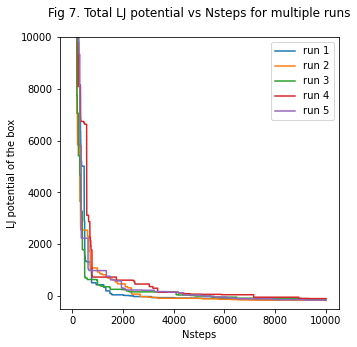

In [0]:
### Convergence of MC simulation (no replica exchange) ###
### (c) To make it easier, plot total potential vs Nstep  ###
def MC_V(N,Nstep,Nmove,T,xlist,ylist,zlist,V):
  '''
  This fn is used to track the average total potential and plot it vs Nstep
  This fn is almost the same as the MC_coor fn defined above. 
  (The only difference is it records the total potential trajectory (not average total potential))
  '''
  counter = 0                               # used for acceptance rate calculation
  Nc = 1                                    # used for counting the steps
  Vlist = [V]                               # save total potential trajectory
  Nlist = [Nc]                              # save 1,2,3,4,....,Nstep
  for i in range(Nstep):
    klist = []                              # ramdomly pick Nmove keys and save in klist
    while len(klist) < Nmove:
      k = randrange(N)
      if k not in klist: klist.append(k)
    xlist_t = []
    ylist_t = []
    zlist_t = []
    for j in range(N):            
      if j in klist:
        deltax = random.uniform(-dx, dx)
        deltay = random.uniform(-dy, dy)
        deltaz = random.uniform(-dz, dz)
        x_t = xlist[j] + deltax
        y_t = ylist[j] + deltay
        z_t = zlist[j] + deltaz
        x_t,y_t,z_t = fix_range(x_t, y_t, z_t)
      else:
        x_t = xlist[j]
        y_t = ylist[j]
        z_t = zlist[j]
      xlist_t.append(x_t)
      ylist_t.append(y_t)
      zlist_t.append(z_t)
    V_t = V_LJ(xlist_t, ylist_t, zlist_t)
    V, xlist, ylist, zlist, counter = decide_LJ(V_t, V, xlist_t, ylist_t, zlist_t, xlist, ylist, zlist, T, counter)
    Nc += 1
    Nlist.append(Nc)
    Vlist.append(V)                         # record the total potential trajectory
  return Vlist, Nlist

Nstep = 10000
Nmove = 5
x_ini, y_ini, z_ini, V_ini = init_coor(N)   # generate initial coordinates and potential (default N=50, boxsize:20*20*0, stepsize:dx=dy=2)
plt.figure(figsize=[5,5])

for i in range(5):      # repeat for 5 runs
  Vlist, Nlist = MC_V(N,Nstep,Nmove,T,x_ini,y_ini,z_ini,V_ini)   # Do MC and return the total potential trajectory (N=50,T=300K)
  plt.plot(Nlist,Vlist,label='run %s'%(i+1))
plt.legend()
plt.xlabel('Nsteps')
plt.ylabel('LJ potential of the box')
plt.ylim(-500,10000)
plt.title('Fig 7. Total LJ potential vs Nsteps for multiple runs',pad=20)

**III. Set up Replica Exchange MD simulation**<br>
Herein, two functions are defined for replica exchange:<br>
(a) Decide function for replica exchange **decide_replica()**<br>
(b) Replica exchange MD simulation function for odd number of temperatures **replica_ex()**<br>

In [0]:
### Replica Exchange Molecular Dynamics ###
### Define functions ###

def decide_replica(T2,V2,x2,y2,z2,T1,V1,x1,y1,z1,counter):   
  '''
  This function is used to decide accepting/rejecting a replica exchange
  Input: Temp, Potential, coordinates of two states
  If accept the exchange: return the switched coordinates and potential
  If reject the exchange: return the original coordinates and potential
  !!!Problem: I'm not sure if this decide process is correct!!!
  '''
  beta2 = 1/(kb*T2)
  beta1 = 1/(kb*T1)
  ratio = np.exp((beta2-beta1)*(V2-V1))
  if ratio >= 1:
    counter += 1
    return V1,x1,y1,z1,V2,x2,y2,z2,counter   # accpet the exchange
  else:
    return V2,x2,y2,z2,V1,x1,y1,z1,counter   # reject the exchange



def replica_ex(N,Nstep,Nomve,T,num_ex):      # num_ex is how many replica exchanges to do 
  '''
  This function is used to apply the replica exchange from the very start
  Step1: initialize N data points
  Step2: Do Monte Carlo to the initialized data points for Nsteps
  Step3: Apply replica_exchange in a loop (eg. for a list of temp [T0,T1,T2,T3,T4], do exchange between T0/T1 then do T2/T3, then do T4&T0, then do T1/T2 ... )
  '''
  ### Step1: initialize N data points ###
  length = len(T)                           # T is a list that has odd number of elements, save the length of T list
  x_ini,y_ini,z_ini,V_ini = init_coor(N)    # generate initial coordinates and potential (default N=50, boxsize:20*20*0, stepsize:dx=dy=2)
  x = [[] for i in range(length)]           # x is a 2d-array. x[i][j] means the x_coord of j'th point(N) at T[i]
  y = [[] for i in range(length)]
  z = [[] for i in range(length)]
  V = [0 for i in range(length)]            # V is a list. V[i] is the potential at T[i]
  V_2d = [[] for i in range(length)]        # V_2d is a 2d-array. V_2d[i][j] is the total LJ potential at T[i] with Nstep*j steps

  ### Step2: Do MC to initialized data points at different Temperatures           
  for i in range(len(T)): 
    x[i], y[i], z[i], V[i], acc_rate = MC_coor(N,Nstep,Nmove,T[i],x_ini,y_ini,z_ini,V_ini)
    V_2d[i].append(V[i])
  
  ### Step3: Apply replica_exchange in a loop ###
  counter = 0
  for i in range(num_ex):
    # pick key1 and key2 (which two temp for replica exchange)
    key1 = (2*i)%length                              
    key2 = (2*i+1)%length
    # decide if taking the replica exchange for key1 and key2 temperatures
    V[key1],x[key1],y[key1],z[key1],V[key2],x[key2],y[key2],z[key2],counter = decide_replica(T[key1],V[key1],x[key1],y[key1],z[key1],T[key2],V[key2],x[key2],y[key2],z[key2],counter)

    # After replica exchange, do MC for Nstep at key1 and key2 temperatures
    x[key1],y[key1],z[key1],V[key1], acc_rate = MC_coor(N,Nstep,Nmove,T[key1],x[key1],y[key1],z[key1],V[key1])
    x[key2],y[key2],z[key2],V[key2], acc_rate = MC_coor(N,Nstep,Nmove,T[key2],x[key2],y[key2],z[key2],V[key2])
    V_2d[key1].append(V[key1])
    V_2d[key2].append(V[key2])

    re_accrate = counter*100/num_ex   # This is the acceptance rate for replica exchange
  
  return x,y,z,V,V_2d,re_accrate

**IV. Test the REMD** (N=50,Nstep=100,Nmove=5,dx=dy=2,epsilon=3)<br>
Herein, the same ergodicity measures should be plotted, but because of the time/space limit and some coding issue, I plot the total potential vs Nstep in Fig 8 instead. In this REMD test, 7 temperatures (300K, 340K, 388K, 446K, 506K, 580K, 671K) are considered for replica exchange. In Fig 8, the acceptance rate of replica exchange is 34%, I'm not sure if it is too high. <br>

Further more, to compare the convergence speed between with/without replica exchange, I will compare Fig 7 and Fig 8 with temp=300K. In Fig 7, the total potential is converged at around Nstep = 6000. In Fig 8, the total potential at 300K is converged at around Nstep = 1000. This demonstrates that Replica Exchange do make the convergence much faster.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


The acceptance rate of replica exchange is  34.44444444444444 %


Text(0.5, 1.0, 'Fig 8. Total LJ potential vs Nsteps at different temp')

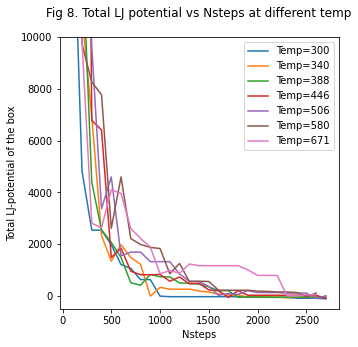

In [0]:
Nstep = 100
Nmove = 5
T = [300,340,388,446,506,580,671]
num_ex = 90    # do num_ex times replica exchanges
x,y,z,V,V_2d,re_accrate = replica_ex(N,Nstep,Nmove,T,num_ex)    # call replica_ex fn
print('The acceptance rate of replica exchange is ', re_accrate, '%')

plt.figure(figsize=[5,5])
for i in range(len(T)):
  length = len(V_2d[i])
  Nlist = []
  for j in range(length):
    Nlist.append(100*(j+1))     # record the Nstep sequence every 100 steps
  plt.plot(Nlist,V_2d[i],label='Temp=%s'%T[i])   # plot total potential trajectory vs Nstep at T[i] temperature

plt.legend()
plt.xlabel('Nsteps')
plt.ylabel('Total LJ-potential of the box')
plt.ylim(-500,10000)
plt.title('Fig 8. Total LJ potential vs Nsteps at different temp',pad=20)